# Overview

Let's implement the Transformer architecture.

* The Positional Encoder Layer
* Multi-Head Self-Attention
* The Encoder Layer

In [1]:
%%capture
!pip install transformers==4.39.3
!pip install -U datasets==2.16.0

# Loading database

In [2]:
from datasets import load_dataset

ds=load_dataset("imdb")
ds

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [3]:
from datasets import DatasetDict

def balance_and_create_dataset(original_dataset, n_train, n_test):
    def get_balanced_split(split, n_samples):
        pos_indices = [i for i, example in enumerate(split) if example['label'] == 1][:n_samples // 2]
        neg_indices = [i for i, example in enumerate(split) if example['label'] == 0][:n_samples // 2]
        balanced_indices = pos_indices + neg_indices
        return split.select(balanced_indices)

    balanced_train_split = get_balanced_split(original_dataset['train'], n_train)
    balanced_test_split = get_balanced_split(original_dataset['test'], n_test)

    balanced_dataset = DatasetDict({
        'train': balanced_train_split,
        'test': balanced_test_split
    })

    return balanced_dataset

ds=balance_and_create_dataset(ds, 1200, 200)
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
})

# Batching data

The first token is the [CLS] token which stands for Classification, this concept from BERT.

In [4]:
from transformers import AutoTokenizer

num_classes=2
d_model=256
num_heads=4
num_layers=4
d_ff=512
sequence_length=256
dropout=0.4
num_epochs=30
batch_size=32

tokenizer=AutoTokenizer.from_pretrained('bert-base-uncased', model_max_length=sequence_length)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
def preprocess(instance):
    return tokenizer(instance['text'], padding="max_length", truncation=True, max_length=sequence_length)

tokenized_datasets=ds.map(preprocess, batched=True)
tokenized_datasets.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label']
)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [6]:
from torch.utils.data import DataLoader

train_dataloader=DataLoader(tokenized_datasets['train'], batch_size=batch_size, shuffle=True)
test_dataloader=DataLoader(tokenized_datasets['test'], batch_size=batch_size, shuffle=True)

In [7]:
vocab_size=tokenizer.vocab_size

# The Positional Encoder Layer

It adds the positional encodings to the input embeddings, using two mathematical functions: cosine and sine.

$$PE_{pos,2i}=sin(\frac{pos}{10000^{2i/d_{model}}})$$

$$PE_{pos, 2i+1}=cos(\frac{pos}{10000^{2i/d_{model}}})$$


The sin and cosine functions take values between -1 and 1 and have useful periodicity properties to help the model leanr patterns about the **relative positions of words.**


# Multi-Head Self Attention

$$Attention(Q,K,V)=softmax(\frac{QK^{T}}{\sqrt{d_{k}}})V$$


# Encoder Layer

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import math

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_length):
        super(PositionalEncoder, self).__init__()
        self.d_model=d_model
        self.max_length=max_length
        
        # Initialize the the positional encoding matrix
        pe=torch.zeros(max_length, d_model)
        
        position=torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term=torch.exp(torch.arange(0, d_model, 2, dtype=torch.float)* -(math.log(10000.0)/d_model))
        
        # calculate and assign position encoding to the matrix
        pe[:,0::2]=torch.sin(position*div_term)
        pe[:,1::2]=torch.cos(position*div_term)
        self.pe=pe.unsqueeze(0)
        
    def forward(self, x):
        x=x+self.pe[:, :x.size(1)] # update embeddings
        return x
    

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads=num_heads
        self.d_model=d_model
        self.head_dim=d_model//num_heads
        
        self.query_linear=nn.Linear(d_model, d_model)
        self.key_linear=nn.Linear(d_model, d_model)
        self.value_linear=nn.Linear(d_model, d_model)
        self.output_linear=nn.Linear(d_model, d_model)
    
    def split_heads(self, x, batch_size):
        """
        split the sequence embeddings in x across the attention heads
        """
        x=x.view(batch_size, -1, self.num_heads, self.head_dim)
        return x.permute(0,2,1,3).contiguous().view(batch_size*self.num_heads,-1,self.head_dim)
    
    def compute_attention(self, query, key, mask=None):
        """
        Use mask to avoid using attention on padded tokens
        """
        scores=query@key.transpose(-2,-1)/math.sqrt(self.head_dim)
        if mask is not None:
            scores=scores.view(-1, scores.shape[0]//self.num_heads, mask.shape[1], mask.shape[2])
            scores=scores.masked_fill(mask==0, float('-1e20'))
            scores=scores.view(-1, mask.shape[1], mask.shape[2])
        attention_weights=F.softmax(scores, dim=-1)
        return attention_weights
    
    def forward(self, query, key, value, mask=None):
        """
        Performs the multi-head logical split and compute the attention weights.
        """
        batch_size=query.size(0)
        query=self.split_heads(self.query_linear(query), batch_size)
        key=self.split_heads(self.key_linear(key), batch_size)
        value=self.split_heads(self.value_linear(value), batch_size)
        
        attention_weights=self.compute_attention(query, key, mask)
        
        # multiply attention weights by values, concatenate and linearly project outputs
        output=torch.matmul(attention_weights, value)
        output=output.view(batch_size, self.num_heads, -1, self.head_dim).permute(0,2,1,3).contiguous().view(batch_size, -1, self.d_model)
        return self.output_linear(output)
    

class FeedForwardSubLayer(nn.Module):
    """
    Performs a feed-forward operation
    """
    def __init__(self, d_model, d_ff):
        super(FeedForwardSubLayer, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForwardSubLayer(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output)) # skip connections before applying normalization
        ff_output = self.feed_forward(x)
        return self.norm2(x + self.dropout(ff_output))


class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoder(d_model, max_sequence_length)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
    
    def forward(self, x, mask):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x
    
class ClassifierHead(nn.Module):
    """
    It is used to transform the final embeddings into class probabilities.
    """
    def __init__(self, d_model, num_classes):
        super(ClassifierHead, self).__init__()
        self.fc=nn.Linear(d_model, num_classes)
        
    def forward(self,x):
        logits=self.fc(x[:,0,:]) # only applied on the first embedding(corresponding to the first token of input sequence)
        return F.softmax(logits, dim=-1)

loss_function=torch.nn.CrossEntropyLoss()

# Training

In [9]:
encoder=TransformerEncoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_sequence_length=sequence_length)

In [10]:
classifier=ClassifierHead(d_model, num_classes)

optimizer=torch.optim.Adam(list(encoder.parameters())+list(classifier.parameters()), lr=1e-4)

In [11]:
import numpy as np
from tqdm import tqdm


def collect_embeddings(encoder, dataloader):
    encoder.eval()
    all_embeddings=[]
    all_labels=[]
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Collecting embeddings"):
            input_ids=batch['input_ids']
            attention_mask=batch['attention_mask']
            attention_mask=attention_mask.unsqueeze(-1)
            attention_mask=attention_mask & attention_mask.transpose(1,2)
            labels=batch['label']
            all_labels.extend(labels.tolist())
            
            output=encoder(input_ids, attention_mask)
            batch_embeddings=[embedding[0,:].cpu().numpy() for embedding in output]
            all_embeddings.extend(batch_embeddings)
    encoder.train()
    return np.array(all_embeddings), all_labels

dic_embeddings=dict()

def train(dataloader, encoder, classifier, optimizer, loss_function, num_epochs):
    for epoch in range(num_epochs):
        # Collect and store embeddings before each epoch starts for visualizaiton purposes
        all_embeddings, all_labels = collect_embeddings(encoder, dataloader)
        reduced_embeddings = visualize_embeddings(all_embeddings, all_labels, epoch, show=False)
        dic_embeddings[epoch] = [reduced_embeddings, all_labels]
        
        encoder.train()
        classifier.train()
        correct_predictions = 0
        total_predictions = 0
        for batch in tqdm(dataloader, desc="Training"):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            attention_mask = attention_mask.unsqueeze(-1)
            attention_mask = attention_mask & attention_mask.transpose(1, 2)
            labels = batch['label']
            optimizer.zero_grad()
            output = encoder(input_ids, attention_mask)
            classification = classifier(output)
            loss = loss_function(classification, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(classification, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)
        
        epoch_accuracy = correct_predictions / total_predictions
        print(f'Epoch {epoch} Training Accuracy: {epoch_accuracy:.4f}')


def test(dataloader, encoder, classifier):
    '''Return accuracy on the test data'''
    encoder.eval()
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Testing"):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            attention_mask = attention_mask.unsqueeze(-1)
            attention_mask = attention_mask & attention_mask.transpose(1, 2)
            labels = batch['label']
            output = encoder(input_ids, attention_mask)
            classification = classifier(output)
            predictions = torch.argmax(classification, dim=1)
            correct += torch.sum(predictions == labels).item()
            total += len(labels)
    print('Test accuracy:', correct / total)

# Visualization

Here we visualize the [CLS] token embedding for each sentence of the training set by using a dimensionality reduction technique called t-SNE which makes data to 2D vectors(instead of 256-dimensional vectors).

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import umap


def plot_animation(data):
    fig, ax = plt.subplots()
    sc = ax.scatter([], [], c=[], cmap='coolwarm', alpha=0.7)
    txt = ax.text(0.8, 0.9, '', transform=ax.transAxes)

    # find max and min values for x and y
    max_x = max([np.max(data[epoch][0][:, 0]) for epoch in data])
    min_x = min([np.min(data[epoch][0][:, 0]) for epoch in data])
    max_y = max([np.max(data[epoch][0][:, 1]) for epoch in data])
    min_y = min([np.min(data[epoch][0][:, 1]) for epoch in data])

    def init():
        ax.set_xlim(min_x - 1, max_x + 1)
        ax.set_ylim(min_y - 1, max_y + 1)
        return sc, txt

    def update(epoch):
        embeddings, labels = data[epoch]
        sc.set_offsets(embeddings)
        sc.set_array(np.array(labels))
        txt.set_text(f'Epoch {epoch + 1}')
        return sc, txt

    ani = FuncAnimation(fig, update, frames=sorted(data.keys()), init_func=init, blit=True, interval=500)

    ani.save('animation2.gif', writer='imagemagick', fps=1.5)


def visualize_embeddings(embeddings, labels, epoch, show=False):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))
    if not show:
        return embeddings_2d
    else:
        plt.figure(figsize=(10, 6))
        # scatter points with 2 different colors based on the labels
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
        # save picture
        plt.savefig(f'epoch_{epoch}.png')
        return embeddings_2d

def visualize_embeddings_umap(embeddings, labels, epoch, show=False):
    reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean', random_state=42)
    embeddings_2d = reducer.fit_transform(np.array(embeddings))
    if not show:
        return embeddings_2d
    else:
        # Create plot
        plt.figure(figsize=(10, 6))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
        
        # Save the plot
        plt.savefig(f'epoch_{epoch}_umap.png')
        return embeddings_2d

2024-04-04 10:09:21.867663: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 10:09:21.867763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 10:09:22.004843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
train(train_dataloader, encoder, classifier, optimizer, loss_function, num_epochs)

Training: 100%|██████████| 38/38 [00:39<00:00,  1.05s/it]


Epoch 0 Training Accuracy: 0.5092


Training: 100%|██████████| 38/38 [00:37<00:00,  1.00it/s]


Epoch 1 Training Accuracy: 0.5092


Training: 100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Epoch 2 Training Accuracy: 0.5508


Training: 100%|██████████| 38/38 [00:39<00:00,  1.03s/it]


Epoch 3 Training Accuracy: 0.5483


Training: 100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch 4 Training Accuracy: 0.6633


Training: 100%|██████████| 38/38 [00:37<00:00,  1.00it/s]


Epoch 5 Training Accuracy: 0.6725


Training: 100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


Epoch 6 Training Accuracy: 0.7108


Training: 100%|██████████| 38/38 [00:39<00:00,  1.03s/it]


Epoch 7 Training Accuracy: 0.7200


Training: 100%|██████████| 38/38 [00:38<00:00,  1.00s/it]


Epoch 8 Training Accuracy: 0.7425


Training: 100%|██████████| 38/38 [00:37<00:00,  1.00it/s]


Epoch 9 Training Accuracy: 0.7700


Training: 100%|██████████| 38/38 [00:37<00:00,  1.02it/s]


Epoch 10 Training Accuracy: 0.7917


Training: 100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


Epoch 11 Training Accuracy: 0.8075


Training: 100%|██████████| 38/38 [00:39<00:00,  1.04s/it]


Epoch 12 Training Accuracy: 0.8192


Training: 100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


Epoch 13 Training Accuracy: 0.8108


Training: 100%|██████████| 38/38 [00:37<00:00,  1.02it/s]


Epoch 14 Training Accuracy: 0.8283


Training: 100%|██████████| 38/38 [00:37<00:00,  1.00it/s]


Epoch 15 Training Accuracy: 0.8558


Training: 100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch 16 Training Accuracy: 0.8692


Training: 100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch 17 Training Accuracy: 0.8892


Training: 100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


Epoch 18 Training Accuracy: 0.8875


Training: 100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch 19 Training Accuracy: 0.9142


Training: 100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch 20 Training Accuracy: 0.8992


Training: 100%|██████████| 38/38 [00:38<00:00,  1.00s/it]


Epoch 21 Training Accuracy: 0.9250


Training: 100%|██████████| 38/38 [00:38<00:00,  1.00s/it]


Epoch 22 Training Accuracy: 0.9342


Training: 100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch 23 Training Accuracy: 0.9358


Training: 100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch 24 Training Accuracy: 0.9342


Training: 100%|██████████| 38/38 [00:37<00:00,  1.00it/s]


Epoch 25 Training Accuracy: 0.9300


Training: 100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Epoch 26 Training Accuracy: 0.9333


Training: 100%|██████████| 38/38 [00:38<00:00,  1.00s/it]


Epoch 27 Training Accuracy: 0.9400


Training: 100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch 28 Training Accuracy: 0.9250


Training: 100%|██████████| 38/38 [00:37<00:00,  1.00it/s]

Epoch 29 Training Accuracy: 0.9250


In [14]:
test(test_dataloader, encoder, classifier)

Testing: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

Test accuracy: 0.685


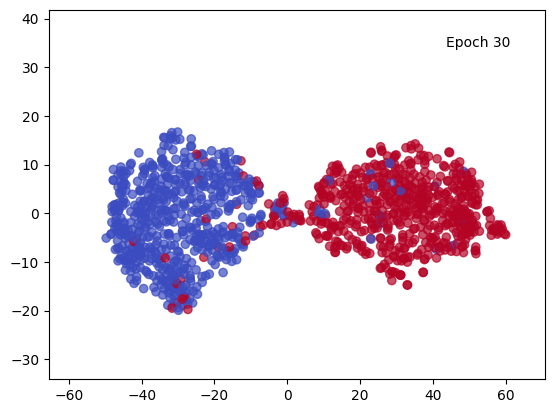

In [15]:
plot_animation(dic_embeddings)

This visual shows the remarkable capability of the Transformer architectures to adapt embeddings over time and highlights the power of the self-attention mechanism. 

# Acknowledge
* https://github.com/maxime7770/Transformers-Insights/blob/main/src/model/layers.py
* https://towardsdatascience.com/transformers-how-do-they-transform-your-data-72d69e383e0d

# Reference
* https://github.com/huggingface/datasets/issues/6753